<a href="https://colab.research.google.com/github/MooNight009/ColabProjects/blob/master/TODO_lstm_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

print("TF version:", tf.__version__)
print("Eagerly:", "enabled" if tf.executing_eagerly else " disabled")
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "unavaible")

TF version: 2.1.0-rc1
Eagerly: enabled
GPU is available


Upload data

In [0]:
# from google.colab import files

# uploaded= files.upload()


Saving data.txt to data.txt


In [0]:
data= pd.read_csv("data.txt", sep=",")

data.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4521.000000,4521.000000,4521.000000,4521.000000,4.521000e+03,4521.0
mean,27.856296,28.270442,27.452486,27.871357,3.993503e+06,0.0
std,12.940880,13.176000,12.711735,12.944389,2.665730e+06,0.0
min,7.223100,7.513900,7.087800,7.323800,0.000000e+00,0.0
25%,19.117000,19.435000,18.780000,19.089000,2.407862e+06,0.0
50%,24.456000,24.809000,24.159000,24.490000,3.460621e+06,0.0
75%,36.502000,37.046000,35.877000,36.521000,4.849809e+06,0.0
max,105.300000,109.370000,97.881000,107.320000,6.627751e+07,0.0


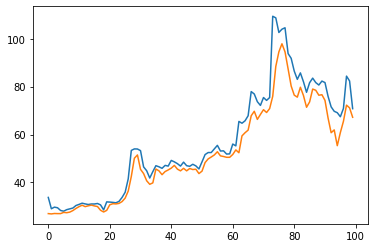

In [0]:
# TODO: Update this
plt.plot(data[['High', 'Low']].values[:100])
plt.show()

In [0]:
def generate_tt(data, train_split= 0.8):
  X= []
  Y= []

  row_values= data[['Open', 'High', 'Low', 'Close']].values
  # print(row_values[0])
  # Scale the data
  scaler= MinMaxScaler(feature_range= (0, 1))
  scaler.fit(row_values[0: int(len(row_values)* train_split)])
  # scaler.fit(row_values)
  row_values= scaler.transform(row_values)
  # print(row_values[0])
  # print(scaler.inverse_transform(row_values[0]))

  # Add data to list
  for i in range(len(row_values)- 1):
    # row_value= np.append(row_values[i], [row_values[i+1][0]]) # This is for adding next day's opening
    row_value= row_values[i]

    X.append(row_value)
    # Y.append(row_values[i+ 1][1:3]) # This is 2 output instead of average
    Y.append([sum(row_values[i+ 1][1:3])/ 2])

  # print(X[0])

  # Split data
  train_features, test_features, train_labels, test_labels= [], [], [], []
  for i in range(len(X)):
    if i/ len(X)<= train_split:
      train_features.append(X[i])
      train_labels.append(Y[i])
    else:
      test_features.append(X[i])
      test_labels.append(Y[i])
  # print(train_features[0])

  # Convert to numpy
  train_features, test_features, train_labels, test_labels= np.array(train_features), np.array(test_features), np.array(train_labels), np.array(test_labels)

  # Reshape for LSTM input
  train_features = np.reshape(train_features, (train_features.shape[0], 1, train_features.shape[1]))
  test_features = np.reshape(test_features, (test_features.shape[0], 1, test_features.shape[1]))
  train_labels = np.reshape(train_labels, (train_labels.shape[0], 1, train_labels.shape[1]))
  test_labels = np.reshape(test_labels, (test_labels.shape[0], 1, test_labels.shape[1]))

  # print(train_features[0])
  # print(scaler.inverse_transform(train_features[0]))

  return train_features, test_features, train_labels, test_labels, scaler

In [0]:
def scale(data, scaler):
  return scaler.transform(data)

def inv_scale(data, scaler):
  return scaler.inverse_transform(data)

def estimate_prediction_output(data, scaler):
  return (scaler.data_range_[1]+ scaler.data_range_[2])/2 * data + (scaler.data_min_[1]+ scaler.data_min_[2])/2

In [0]:
def create_model(learning_rate= 0.0001, dropout_rate= 0.3, batch_size= 1):
  model= tf.keras.Sequential()
  model.add(tf.keras.layers.LSTM(50, activation= 'tanh', recurrent_activation= 'sigmoid', dropout= dropout_rate, return_sequences=True, stateful=False, input_shape= (1, 4, )))
  model.add(tf.keras.layers.LSTM(100, activation= 'tanh', recurrent_activation= 'sigmoid', dropout= dropout_rate, return_sequences=True, stateful=False))
  # model.add(tf.keras.layers.LSTM(50, activation= 'tanh', recurrent_activation= 'sigmoid', return_sequences=True, input_shape=(1, 4, )))
  # model.add(tf.keras.layers.Dropout(dropout_rate))
  # model.add(tf.keras.layers.LSTM(100, activation= 'tanh', recurrent_activation= 'sigmoid', return_sequences=False))
  # model.add(tf.keras.layers.Dropout(dropout_rate))
  model.add(tf.keras.layers.Dense(1, activation= 'relu' ))

  model.compile(
      optimizer= tf.keras.optimizers.RMSprop(learning_rate),
      loss= 'mse'
  )
  # model.summary()
  return model

In [0]:
train_features, test_features, train_labels, test_labels, scaler= generate_tt(data, train_split= 0.8)


# batch_size= 128
model= create_model(learning_rate= 0.0003, dropout_rate= 0.0, batch_size= 128)

model.fit(
    x= train_features,
    y= train_labels,
    batch_size= 128,
    epochs= 100,
    verbose= 1,
    validation_split= 0.05,
    shuffle= False
)

s= model.evaluate(
    x= test_features,
    y= test_labels,
    batch_size= 128,
    verbose= 1,
)
print(s)

Train on 3436 samples, validate on 181 samples
Epoch 1/100
3436/3436 [==============================] - 3s 733us/sample - loss: 0.0312 - val_loss: 0.0658
Epoch 2/100
3436/3436 [==============================] - 0s 58us/sample - loss: 0.0201 - val_loss: 0.0434
Epoch 3/100
3436/3436 [==============================] - 0s 50us/sample - loss: 0.0126 - val_loss: 0.0268
Epoch 4/100
3436/3436 [==============================] - 0s 45us/sample - loss: 0.0087 - val_loss: 0.0172
Epoch 5/100
3436/3436 [==============================] - 0s 45us/sample - loss: 0.0071 - val_loss: 0.0127
Epoch 6/100
3436/3436 [==============================] - 0s 45us/sample - loss: 0.0065 - val_loss: 0.0106
Epoch 7/100
3436/3436 [==============================] - 0s 44us/sample - loss: 0.0061 - val_loss: 0.0095
Epoch 8/100
3436/3436 [==============================] - 0s 48us/sample - loss: 0.0057 - val_loss: 0.0086
Epoch 9/100
3436/3436 [==============================] - 0s 48us/sample - loss: 0.0053 - val_loss: 0.007

In [0]:

n= len(test_features)+ 0
# n= 0
print(inv_scale(test_features[len(test_features)- n- 1], scaler))
print(estimate_prediction_output(test_labels[len(test_features)- n- 1], scaler))

estimate_prediction_output(model.predict(np.reshape(test_features[len(test_features)- n- 1], (1, 1, 4))), scaler)

[[67.92 67.98 66.91 67.47]]
[[67.32490504]]


array([[[67.369705]]], dtype=float32)

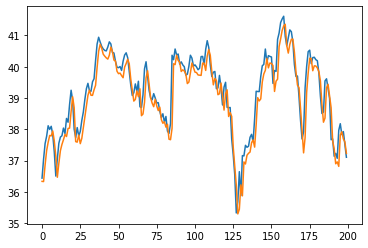

In [0]:
plt.plot(estimate_prediction_output(test_labels, scaler).reshape(903, 1)[:200])
plt.plot(estimate_prediction_output(model.predict(test_features), scaler).reshape(903, 1)[:200])
plt.show()

### Grid Search for finding the parameters

In [0]:
train_features, test_features, train_labels, test_labels, scaler= generate_tt(data, train_split= 0.8)

# lr= [0.1, 0.01, 0.001, 0.003, 0.0001, 0.0003]
# dr= [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# bs= [256, 128, 64, 32, 16, 8, 4, 2, 1]

lr= [0.003, 0.01, 0.001, 0.0001, 0.0003, 0.00001]
dr= [0.0, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
bs= [64, 128, 32, 256, 16, 8, 4, 2, 1]

result= []

for z in bs:
  for i in lr:
    for j in dr:
      minLoss= 99
      for n in range(3):

        model= create_model(learning_rate= i, dropout_rate= j)

        model.fit(
            x= train_features,
            y= train_labels,
            batch_size= z,
            epochs= 100,
            verbose= 0,
            validation_split= 0.05,
            shuffle= False
        )

        test_loss= model.evaluate(
            x= test_features,
            y= test_labels,
            batch_size= z,
            verbose= 0,
        )
        print(test_loss)
        if test_loss< minLoss:
          minLoss= test_loss
      res= [i, j, z, minLoss]
      result.append(res)
      print(res)


0.00121263318859115
0.0019569167875553815
0.0001212821781928192
[0.003, 0.0, 64, 0.0001212821781928192]
0.004671689141479838
0.002709483950587602
0.0034657274821519456
[0.003, 0.05, 64, 0.002709483950587602]
0.0002151334746962502
7.691692605002031e-05
8.965467634236446e-05
[0.003, 0.01, 64, 7.691692605002031e-05]
0.006689384695171385
0.008894361654587362
0.008590761931037586
[0.003, 0.1, 64, 0.006689384695171385]
0.013621937545431017
0.01160121099777924
0.012686416927564184
[0.003, 0.2, 64, 0.01160121099777924]
0.01863348699388314
0.017758351500050173
0.018053891782876794
[0.003, 0.3, 64, 0.017758351500050173]
0.0236830890327197
0.02446098648762518
0.023731262399376694
[0.003, 0.4, 64, 0.0236830890327197]
0.0263825841701836
0.025797757677989676
0.02874691403189371
[0.003, 0.5, 64, 0.025797757677989676]
0.032922698430312695
0.030901125515682224
0.03274481397860602
[0.003, 0.6, 64, 0.030901125515682224]
0.0003232819307698628
0.15839421910833018
0.0006782716240193426
[0.01, 0.0, 64, 0.000

In [0]:
# result is for the 2 output
# result2 is for the average output
# print(result)
[0.0003, 0.01, 256, 2.3202924029237036e-05]
res1= np.array(result2)
plt.scatter(res1[:, 2], res1[:, 3])
plt.show()


print(np.min(res1[:, 3]))

for r in res1:
  if r[3]== np.min(res1[:, 3]):
    print(r)

NameError: ignored